## Corona cases and deaths for Germany

data from https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
from os import walk
import dateutil.parser

/Users/daniel/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
start_date = datetime(2020, 3, 1)
end_date = datetime.now().date() - timedelta(days=2)

(_, _, filenames) = next(walk('./RKI data'))
file_names = [name for name in filenames if name.startswith('RKI_COVID19')]
file_names.sort()
all_dfs = [pd.read_csv('./RKI data/' + file_names, parse_dates=['Meldedatum'])
           for file_names in file_names]
df_raw = all_dfs[-1]
df_raw['Meldedatum'] = df_raw['Meldedatum'].dt.tz_localize(None)
df_raw['Refdatum'] = pd.to_datetime(df_raw['Refdatum'])
df = df_raw.query('Meldedatum > @start_date' 
              ' and Meldedatum <= @end_date')

f"Found {df['AnzahlFall'].sum():,} cases downloaded at {file_names[-1][12:26]}"

'Found 325,833 cases downloaded at 2020-04-17_22h'

In [45]:
df[:3].columns

Index(['Unnamed: 0', 'IdBundesland', 'Bundesland', 'Landkreis', 'Altersgruppe',
       'Geschlecht', 'AnzahlFall', 'AnzahlTodesfall', 'ObjectId', 'Meldedatum',
       'IdLandkreis', 'Datenstand', 'NeuerFall', 'NeuerTodesfall', 'Refdatum',
       'NeuGenesen', 'AnzahlGenesen'],
      dtype='object')

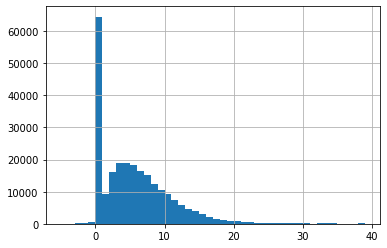

In [42]:
(df['Meldedatum'] - df['Refdatum']).dt.days.hist(bins=range(-5, 40))

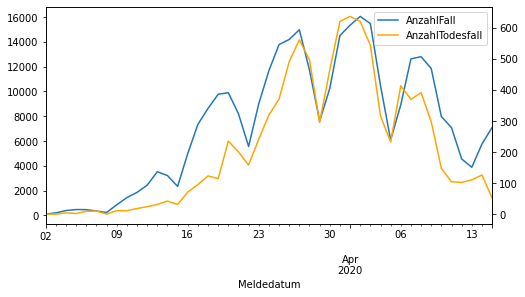

In [3]:
daily_totals = df.groupby('Meldedatum')[['AnzahlFall', 'AnzahlTodesfall']].sum()

def plot_on_2_axes(to_plot1, to_plot2):
    to_plot1.plot(figsize=(8,4))
    ax = plt.gca()
    ax2 = ax.twinx()
    to_plot2.plot(ax=ax2, color='orange')
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

plot_on_2_axes(daily_totals['AnzahlFall'], daily_totals['AnzahlTodesfall'])

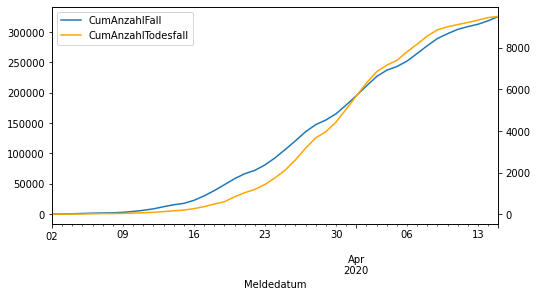

In [4]:
daily_totals['CumAnzahlFall'] = daily_totals['AnzahlFall'].cumsum()
daily_totals['CumAnzahlTodesfall'] = daily_totals['AnzahlTodesfall'].cumsum()
plot_on_2_axes(daily_totals['CumAnzahlFall'], daily_totals['CumAnzahlTodesfall'])

Text(0.5, 1.0, 'Doubling Time')

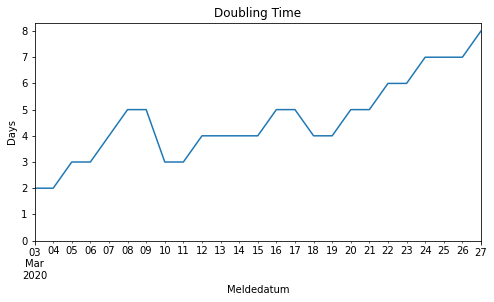

In [26]:
half_indices = []
for day_value in daily_totals['CumAnzahlFall']:
    half_idx = np.searchsorted(daily_totals['CumAnzahlFall'], day_value / 2)
    half_indices.append(half_idx)
half_indices = pd.Series(half_indices)
double_time = half_indices.index - half_indices
double_time.index = daily_totals.index
(double_time + 2)[1:].plot(figsize=(8,4))
plt.ylim(0)
plt.ylabel('Days')
plt.title('Doubling Time')

In [27]:
def cum_sum_by(by, of='AnzahlFall'):
    df_by = df.groupby([by, 'Meldedatum'])[of]\
        .sum()\
        .reset_index()
    df_by['Cum' + of] = df_by.groupby(by)[of].cumsum()
    return df_by

by_state = cum_sum_by('Bundesland')
last_sum = by_state.query('Meldedatum == @end_date')[['Bundesland', 'CumAnzahlFall']].sort_values(by='CumAnzahlFall', ascending=False)
top_8 = last_sum['Bundesland'][:8]
bottom_8 = last_sum['Bundesland'][8:]

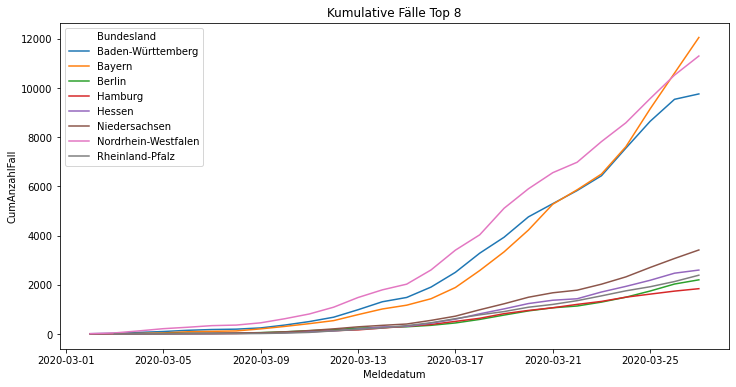

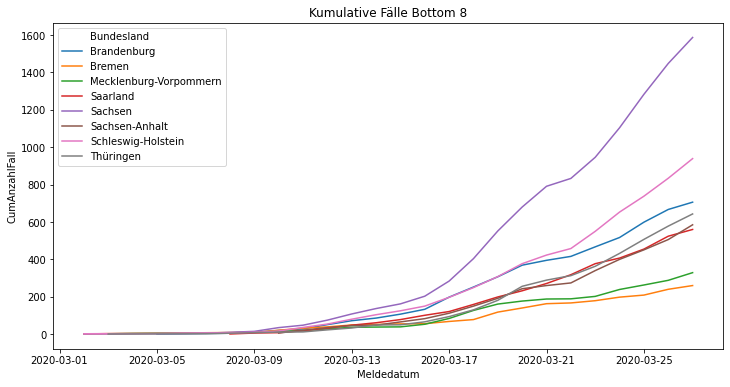

In [31]:
def plot_states(state_list, title):
    to_plot = by_state.query('Bundesland in @state_list')

    plt.figure(figsize=(12,6))
    sns.lineplot(x='Meldedatum', y='CumAnzahlFall', hue='Bundesland', data=to_plot)
    # plt.yscale('log')
    plt.title('Kumulative Fälle ' + title)
    
plot_states(top_8, 'Top 8')
plot_states(bottom_8, 'Bottom 8')

## Landkreise

In [ ]:
by_district = cum_sum_by('Landkreis')
last_district_values = by_district.query('Meldedatum == @end_date')
last_district_values.set_index('Landkreis')['CumAnzahlFall'].sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,4))

In [ ]:
last_district_values['CumAnzahlFall'].sort_values(ascending=False).reset_index(drop=True).plot()
plt.show()
_ = last_district_values['CumAnzahlFall'].sort_values(ascending=False).cumsum().reset_index(drop=True).plot()

## Covariates

### Age

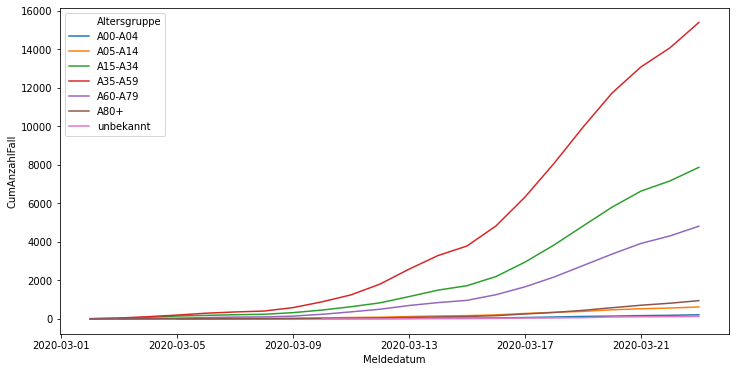

In [193]:
plt.figure(figsize=(12,6))
by_age = cum_sum_by('Altersgruppe')
sns.lineplot(x='Meldedatum', y='CumAnzahlFall', hue='Altersgruppe', data=by_age)
#plt.yscale('log')

In [194]:
A15_A34 = by_age.query("Altersgruppe == 'A15-A34'")
A35_A59 = by_age.query("Altersgruppe == 'A35-A59'")
A60_A79 = by_age.query("Altersgruppe == 'A60-A79'")

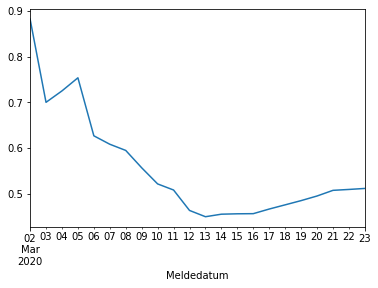

In [195]:
young_mid_ratio = A15_A34.merge(A35_A59, on='Meldedatum')
young_mid_ratio['ratio'] = young_mid_ratio['CumAnzahlFall_x'] / young_mid_ratio['CumAnzahlFall_y']
young_mid_ratio.set_index('Meldedatum')['ratio'].plot()

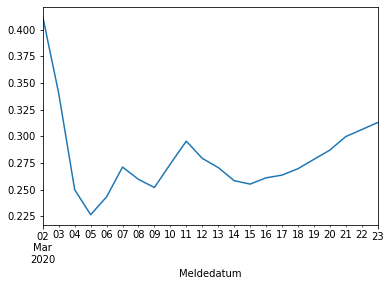

In [196]:
old_mid_ratio = A60_A79.merge(A35_A59, on='Meldedatum')
old_mid_ratio['ratio'] = old_mid_ratio['CumAnzahlFall_x'] / old_mid_ratio['CumAnzahlFall_y']
old_mid_ratio.set_index('Meldedatum')['ratio'].plot()

### Sex

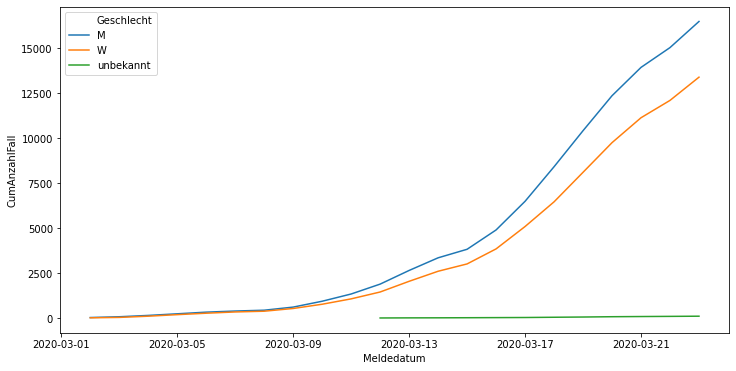

In [197]:
plt.figure(figsize=(12,6))
by_sex = cum_sum_by('Geschlecht')
sns.lineplot(x='Meldedatum', y='CumAnzahlFall', hue='Geschlecht', data=by_sex)

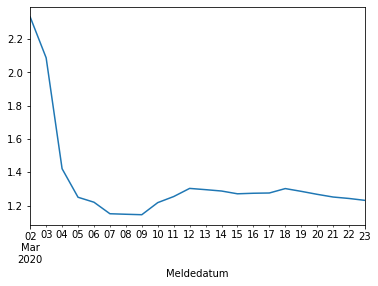

In [198]:
male = by_sex.query("Geschlecht == 'M'")
female = by_sex.query("Geschlecht == 'W'")
sex_ratio = male.merge(female, on='Meldedatum')
sex_ratio['ratio'] = sex_ratio['CumAnzahlFall_x'] / sex_ratio['CumAnzahlFall_y']
sex_ratio.set_index('Meldedatum')['ratio'].plot()